# Práctica 1: Graph Neural Networks

### Índice
- **Funciones a utilizar** — Imports, utilidades, modelos y clase de entrenamiento
- **Ejercicio 1** — Custom Synthetic Dataset
- **Ejercicio 2** — Node Classification Experiments

---
## Funciones a utilizar

In [1]:
# Imports necesarios
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree

# Configuración de reproducibilidad
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Definir dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Using device: {device}")
print("Setup completado")

PyTorch version: 2.7.1+cu118
CUDA available: True
Using device: cuda
Setup completado


### Funciones utilitarias

In [2]:
def create_masks(num_nodes, num_classes, train_ratio = 0.6, val_ratio = 0.2, seed = 0):
    """
    Create train/val/test masks for node classification.
    
    Args:
        num_nodes: Total number of nodes
        num_classes: Number of classes
        train_ratio: Fraction of nodes for training
        val_ratio: Fraction of nodes for validation
        seed: Random seed for reproducibility
    
    Returns:
        train_mask, val_mask, test_mask as boolean tensors
    """
    np.random.seed(seed)
    
    indices = np.random.permutation(num_nodes)
    train_size = int(num_nodes * train_ratio)
    val_size = int(num_nodes * val_ratio)
    
    train_idx = indices[:train_size]
    val_idx = indices[train_size:train_size + val_size]
    test_idx = indices[train_size + val_size:]
    
    train_mask = torch.zeros(num_nodes, dtype = torch.bool)
    val_mask = torch.zeros(num_nodes, dtype = torch.bool)
    test_mask = torch.zeros(num_nodes, dtype = torch.bool)
    
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True
    
    return train_mask, val_mask, test_mask


def efficient_message_passing(x, edge_index, weight_matrix):
    """
    Efficient message passing using scatter operations.
    
    Args:
        x: Node features [num_nodes, in_features]
        edge_index: Graph connectivity [2, num_edges]
        weight_matrix: Learnable weights [in_features, out_features]
    
    Returns:
        Updated node features [num_nodes, out_features]
    """
    num_nodes = x.size(0)
    
    # Transform features
    x_transformed = x @ weight_matrix
    
    # Get source and target nodes
    source_nodes = edge_index[0]
    target_nodes = edge_index[1]
    
    # Gather source node features for each edge
    messages = x_transformed[source_nodes]  # [num_edges, out_features]
    
    # Scatter-add: aggregate messages to target nodes
    out = torch.zeros(num_nodes, x_transformed.size(1))
    out.scatter_add_(0, target_nodes.unsqueeze(1).expand_as(messages), messages)
    
    # Normalize by degree
    deg = degree(target_nodes, num_nodes = num_nodes)
    deg = torch.clamp(deg, min = 1)
    out = out / deg.unsqueeze(1)
    
    # Apply non-linearity
    out = F.relu(out)
    
    return out

### Funciones de visualización

In [3]:
def visualize_embeddings(embeddings, labels, title, filename, num_classes = 4):
    """
    Visualize node embeddings using t-SNE.
    
    Args:
        embeddings: Node embeddings [num_nodes, embedding_dim]
        labels: Node labels [num_nodes]
        title: Plot title
        filename: Output filename
        num_classes: Number of classes for the color map
    """
    # Apply t-SNE (ensure CPU tensors for numpy conversion)
    tsne = TSNE(n_components = 2, random_state = 42, perplexity = 30)
    embeddings_2d = tsne.fit_transform(embeddings.detach().cpu().numpy())
    
    # Plot
    plt.figure(figsize = (10, 8))
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628', '#f781bf']
    
    for class_idx in range(num_classes):
        mask = labels == class_idx
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c = colors[class_idx % len(colors)],
            label = f'Class {class_idx}',
            alpha = 0.7,
            s = 50
        )
    
    plt.legend()
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.tight_layout()
    plt.savefig(filename, dpi = 150)
    plt.show()


@torch.no_grad()
def get_embeddings(model, data):
    """
    Extract node embeddings from the model (before the final layer).
    Handles CUDA: moves data to model's device, returns CPU tensors.
    """
    model.eval()
    dev = next(model.parameters()).device
    x = data.x.to(dev)
    edge_index = data.edge_index.to(dev)
    
    if isinstance(model, GCN):
        x = model.conv1(x, edge_index)
        x = F.relu(x)
        return x.cpu()
    else:
        x = model.fc1(x)
        x = F.relu(x)
        return x.cpu()

### Modelos

In [4]:
class MLP(nn.Module):
    """
    Simple Multi-Layer Perceptron for node classification.
    This baseline ignores the graph structure.
    """
    
    def __init__(self, in_channels, hidden_channels, out_channels, dropout = 0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # First layer
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        # Second layer (output)
        x = self.fc2(x)
        return x


class GCN(nn.Module):
    """
    Graph Convolutional Network for node classification.
    """
    
    def __init__(self, in_channels, hidden_channels, out_channels, dropout = 0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        # Second GCN layer
        x = self.conv2(x, edge_index)
        return x

### Clase de entrenamiento (`GraphTrainer`)

Clase unificada que permite:
- Elegir hiperparámetros (epochs, lr, weight_decay, hidden_channels, dropout, optimizer)
- Entrenar uno o varios modelos sobre uno o varios datasets
- Obtener DataFrames de entrenamiento y resultados finales
- Visualizar curvas de entrenamiento y gráfico de barras comparativo

In [5]:
class GraphTrainer:
    """
    Unified training class for graph node classification experiments.
    Supports training one or multiple models on one or multiple datasets.
    All training data is stored in DataFrames instead of printed.
    Includes early stopping based on validation accuracy and CUDA support.
    """
    
    def __init__(self, num_epochs = 200, lr = 0.01, weight_decay = 5e-4,
                 hidden_channels = 64, dropout = 0.5, optimizer_type = 'Adam',
                 patience = 20, device = None):
        self.num_epochs = num_epochs
        self.lr = lr
        self.weight_decay = weight_decay
        self.hidden_channels = hidden_channels
        self.dropout = dropout
        self.optimizer_type = optimizer_type
        self.patience = patience
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Internal storage
        self._results = []       # Per-run summary results
        self._histories = []     # Per-run epoch-level histories
    
    # ── Private: optimizer factory ──────────────────────────────────────
    def _create_optimizer(self, model):
        if self.optimizer_type == 'Adam':
            return torch.optim.Adam(model.parameters(), lr = self.lr, weight_decay = self.weight_decay)
        elif self.optimizer_type == 'SGD':
            return torch.optim.SGD(model.parameters(), lr = self.lr, weight_decay = self.weight_decay)
        else:
            raise ValueError(f"Optimizer '{self.optimizer_type}' not supported. Use 'Adam' or 'SGD'.")
    
    # ── Private: single epoch ───────────────────────────────────────────
    def _train_epoch(self, model, data, optimizer, criterion, train_mask):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        if isinstance(model, MLP):
            out = model(data.x)
        else:
            out = model(data.x, data.edge_index)
        
        # Compute loss only on training nodes
        loss = criterion(out[train_mask], data.y[train_mask])
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        return loss.item()
    
    # ── Private: evaluate ───────────────────────────────────────────────
    @torch.no_grad()
    def _evaluate(self, model, data, mask):
        model.eval()
        
        # Forward pass
        if isinstance(model, MLP):
            out = model(data.x)
        else:
            out = model(data.x, data.edge_index)
        
        # Get predictions
        pred = out.argmax(dim = 1)
        
        # Compute accuracy
        correct = (pred[mask] == data.y[mask]).sum().item()
        total = mask.sum().item()
        
        return correct / total
    
    # ── Private: run single experiment (early stopping + CUDA) ──────────
    def _run_single(self, model, data, masks):
        # Move model to device (CUDA if available)
        model = model.to(self.device)
        
        # Create data copy on device (avoids modifying the original)
        data_dev = Data(
            x = data.x.to(self.device),
            edge_index = data.edge_index.to(self.device),
            y = data.y.to(self.device)
        )
        
        optimizer = self._create_optimizer(model)
        criterion = nn.CrossEntropyLoss()
        
        train_mask = masks['train'].to(self.device)
        val_mask = masks['val'].to(self.device)
        test_mask = masks['test'].to(self.device)
        
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_acc': [],
            'test_acc': []
        }
        
        best_val_acc = 0
        best_test_acc = 0
        patience_counter = 0
        
        for epoch in range(self.num_epochs):
            # Training
            loss = self._train_epoch(model, data_dev, optimizer, criterion, train_mask)
            
            # Evaluation
            train_acc = self._evaluate(model, data_dev, train_mask)
            val_acc = self._evaluate(model, data_dev, val_mask)
            test_acc = self._evaluate(model, data_dev, test_mask)
            
            # Store history
            history['train_loss'].append(loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['test_acc'].append(test_acc)
            
            # Track best model based on validation accuracy
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_test_acc = test_acc
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Early stopping based on validation accuracy
            if self.patience > 0 and patience_counter >= self.patience:
                break
        
        return {
            'history': history,
            'best_val_acc': best_val_acc,
            'best_test_acc': best_test_acc,
            'epochs_trained': len(history['train_loss'])
        }
    
    # ── Public: train ───────────────────────────────────────────────────
    def train(self, datasets, model_classes, masks_dict = None):
        """
        Train models on datasets. No prints — everything stored internally.
        
        Args:
            datasets:      dict {name: PyG Data}
                           e.g. {'Custom': data} or {'Cora': cora_data, 'Citeseer': cite_data}
            model_classes: dict {name: class}
                           e.g. {'MLP': MLP, 'GCN': GCN}
            masks_dict:    dict {dataset_name: list of mask dicts} or None.
                           If None, uses data.train_mask / val_mask / test_mask (single run).
        """
        self._results = []
        self._histories = []
        
        total_tasks = 0
        for ds_name, data in datasets.items():
            ds_masks = masks_dict.get(ds_name) if masks_dict else None
            if ds_masks is None:
                ds_masks = [{'train': data.train_mask, 'val': data.val_mask, 'test': data.test_mask}]
            total_tasks += len(model_classes) * len(ds_masks)
        
        pbar = tqdm(total = total_tasks, desc = 'Training')
        
        for ds_name, data in datasets.items():
            ds_masks = masks_dict.get(ds_name) if masks_dict else None
            if ds_masks is None:
                ds_masks = [{'train': data.train_mask, 'val': data.val_mask, 'test': data.test_mask}]
            
            num_classes = int(data.y.max()) + 1
            
            for model_name, model_cls in model_classes.items():
                for run_idx, masks in enumerate(ds_masks):
                    # Create fresh model for each run
                    model = model_cls(
                        in_channels = data.num_node_features,
                        hidden_channels = self.hidden_channels,
                        out_channels = num_classes,
                        dropout = self.dropout
                    )
                    
                    result = self._run_single(model, data, masks)
                    
                    self._results.append({
                        'Dataset': ds_name,
                        'Model': model_name,
                        'Run': run_idx,
                        'Best Val Acc': result['best_val_acc'],
                        'Best Test Acc': result['best_test_acc'],
                        'Epochs Trained': result['epochs_trained'],
                    })
                    self._histories.append({
                        'dataset': ds_name,
                        'model': model_name,
                        'run': run_idx,
                        'history': result['history'],
                    })
                    pbar.update(1)
        
        pbar.close()
    
    # ── Public: get training DataFrame ──────────────────────────────────
    def get_training_df(self, dataset_name = None, model_name = None, run = 0):
        """
        Returns a DataFrame with epoch-by-epoch training data for a specific
        dataset/model/run combination.
        """
        for h in self._histories:
            match = True
            if dataset_name and h['dataset'] != dataset_name:
                match = False
            if model_name and h['model'] != model_name:
                match = False
            if h['run'] != run:
                match = False
            if match:
                df = pd.DataFrame(h['history'])
                df.index.name = 'Epoch'
                df.columns = ['Train Loss', 'Train Acc', 'Val Acc', 'Test Acc']
                return df
        return pd.DataFrame()
    
    # ── Public: get results summary DataFrame ───────────────────────────
    def get_results_df(self):
        """
        Returns a summary DataFrame with mean ± std of test and val accuracy
        for each dataset/model combination. Includes avg epochs trained (early stopping).
        """
        df = pd.DataFrame(self._results)
        summary = df.groupby(['Dataset', 'Model']).agg(
            Mean_Test  = ('Best Test Acc', 'mean'),
            Std_Test   = ('Best Test Acc', 'std'),
            Mean_Val   = ('Best Val Acc', 'mean'),
            Std_Val    = ('Best Val Acc', 'std'),
            Runs       = ('Run', 'count'),
            Avg_Epochs = ('Epochs Trained', 'mean')
        ).reset_index()
        
        summary['Std_Test'] = summary['Std_Test'].fillna(0)
        summary['Std_Val'] = summary['Std_Val'].fillna(0)
        
        summary['Test Accuracy'] = summary.apply(
            lambda r: f"{r['Mean_Test']:.4f} ± {r['Std_Test']:.4f}" if r['Runs'] > 1
            else f"{r['Mean_Test']:.4f}", axis = 1
        )
        summary['Val Accuracy'] = summary.apply(
            lambda r: f"{r['Mean_Val']:.4f} ± {r['Std_Val']:.4f}" if r['Runs'] > 1
            else f"{r['Mean_Val']:.4f}", axis = 1
        )
        summary['Avg Epochs'] = summary['Avg_Epochs'].apply(lambda x: f"{x:.0f}")
        return summary[['Dataset', 'Model', 'Test Accuracy', 'Val Accuracy', 'Runs', 'Avg Epochs']]
    
    # ── Public: plot training curves ────────────────────────────────────
    def plot_training_curves(self, dataset_name = None, run = 0, filename = None):
        """
        Plot training curves (loss, train acc, val acc) for all models
        in each dataset. If dataset_name is given, only that dataset is plotted.
        """
        histories = [h for h in self._histories if h['run'] == run]
        if dataset_name:
            histories = [h for h in histories if h['dataset'] == dataset_name]
        
        datasets_in_hist = sorted(set(h['dataset'] for h in histories))
        
        for ds in datasets_in_hist:
            ds_histories = [h for h in histories if h['dataset'] == ds]
            
            fig, axes = plt.subplots(1, 3, figsize = (15, 4))
            fig.suptitle(f'Training Curves — {ds}', fontsize = 14, fontweight = 'bold')
            
            for h in ds_histories:
                hist = h['history']
                label = h['model']
                axes[0].plot(hist['train_loss'], label = label, alpha = 0.8)
                axes[1].plot(hist['train_acc'], label = label, alpha = 0.8)
                axes[2].plot(hist['val_acc'], label = label, alpha = 0.8)
            
            axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Training Loss')
            axes[0].set_title('Training Loss'); axes[0].legend(); axes[0].grid(True, alpha = 0.3)
            axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
            axes[1].set_title('Training Accuracy'); axes[1].legend(); axes[1].grid(True, alpha = 0.3)
            axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('Accuracy')
            axes[2].set_title('Validation Accuracy'); axes[2].legend(); axes[2].grid(True, alpha = 0.3)
            
            plt.tight_layout()
            if filename:
                save_name = f"{filename}_{ds}.png" if len(datasets_in_hist) > 1 else f"{filename}.png"
                plt.savefig(save_name, dpi = 150, bbox_inches = 'tight')
            plt.show()
    
    # ── Public: plot bar chart ──────────────────────────────────────────
    def plot_bar_chart(self, filename = None):
        """
        Plot grouped bar chart comparing model test accuracies across datasets.
        """
        df = pd.DataFrame(self._results)
        summary = df.groupby(['Dataset', 'Model'])['Best Test Acc'].agg(['mean', 'std']).reset_index()
        summary['std'] = summary['std'].fillna(0)
        
        datasets = summary['Dataset'].unique()
        models = summary['Model'].unique()
        
        fig, ax = plt.subplots(figsize = (max(6, len(datasets) * 2.5), 5))
        x = np.arange(len(datasets))
        width = 0.8 / len(models)
        
        for i, model in enumerate(models):
            model_data = summary[summary['Model'] == model]
            means = [model_data[model_data['Dataset'] == ds]['mean'].values[0] for ds in datasets]
            stds  = [model_data[model_data['Dataset'] == ds]['std'].values[0] for ds in datasets]
            offset = (i - len(models) / 2 + 0.5) * width
            bars = ax.bar(x + offset, means, width, yerr = stds, label = model, capsize = 4, alpha = 0.85)
            for bar, mean_val in zip(bars, means):
                ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 0.015,
                        f'{mean_val:.3f}', ha = 'center', va = 'bottom', fontsize = 9)
        
        ax.set_xlabel('Dataset')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Model Comparison — Test Accuracy')
        ax.set_xticks(x)
        ax.set_xticklabels(datasets)
        ax.legend()
        ax.grid(True, alpha = 0.3, axis = 'y')
        ax.set_ylim([0, 1.1])
        
        plt.tight_layout()
        if filename:
            plt.savefig(filename, dpi = 150, bbox_inches = 'tight')
        plt.show()

---
## Ejercicio 1: Custom Synthetic Dataset

*(Espacio para texto descriptivo sobre las decisiones de diseño del dataset sintético)*

In [6]:
# Parameters for our synthetic graph
num_nodes = 2000
num_classes = 4
nodes_per_class = num_nodes // num_classes
feature_dim = 16

# Create a stochastic block model graph
# This generates a graph with community structure
sizes = [nodes_per_class] * num_classes
# Probability matrix: higher probability within communities
p_intra = 0.15  # Probability of edge within same community
p_inter = 0.0001  # Probability of edge between different communities
probs = np.full((num_classes, num_classes), p_inter)
np.fill_diagonal(probs, p_intra)

G = nx.stochastic_block_model(sizes, probs, seed = 42)

# Get the ground truth community assignments
node_labels = np.array([i // nodes_per_class for i in range(num_nodes)])

# Create class centers in the feature space with SMALL magnitude
# The key difference: small class centers and large noise
class_centers = np.random.randn(num_classes, feature_dim) * 0.3

# Assign features to nodes based on their class
# Each node gets a WEAK class signal drowned in LARGE noise
node_features = np.zeros((num_nodes, feature_dim))
for i in range(num_nodes):
    label = node_labels[i]
    # Large noise dominates the weak class signal
    noise = np.random.randn(feature_dim) * 1.0            # Large noise
    weak_signal = class_centers[label] * 0.2              # Weak signal
    node_features[i] = weak_signal + noise

# Convert features and labels to PyTorch tensors
x = torch.tensor(node_features, dtype = torch.float)
y = torch.tensor(node_labels, dtype = torch.long)

# Convert NetworkX graph to edge_index format
# PyG uses COO format: edge_index[0] contains source nodes, edge_index[1] contains target nodes
edge_list = list(G.edges())
edge_index = torch.tensor(edge_list, dtype = torch.long).t().contiguous()

# For undirected graphs, we need edges in both directions
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim = 1)

# Create the PyG Data object
custom_data = Data(x = x, edge_index = edge_index, y = y)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Feature matrix shape: {node_features.shape}")
print(f"Feature statistics - Mean: {node_features.mean():.3f}, Std: {node_features.std():.3f}")
print(f"Number of classes: {num_classes}")
print(f"Is undirected: {custom_data.is_undirected()}")

Number of nodes: 2000
Number of edges: 75148
Feature matrix shape: (2000, 16)
Feature statistics - Mean: -0.012, Std: 1.001
Number of classes: 4
Is undirected: True


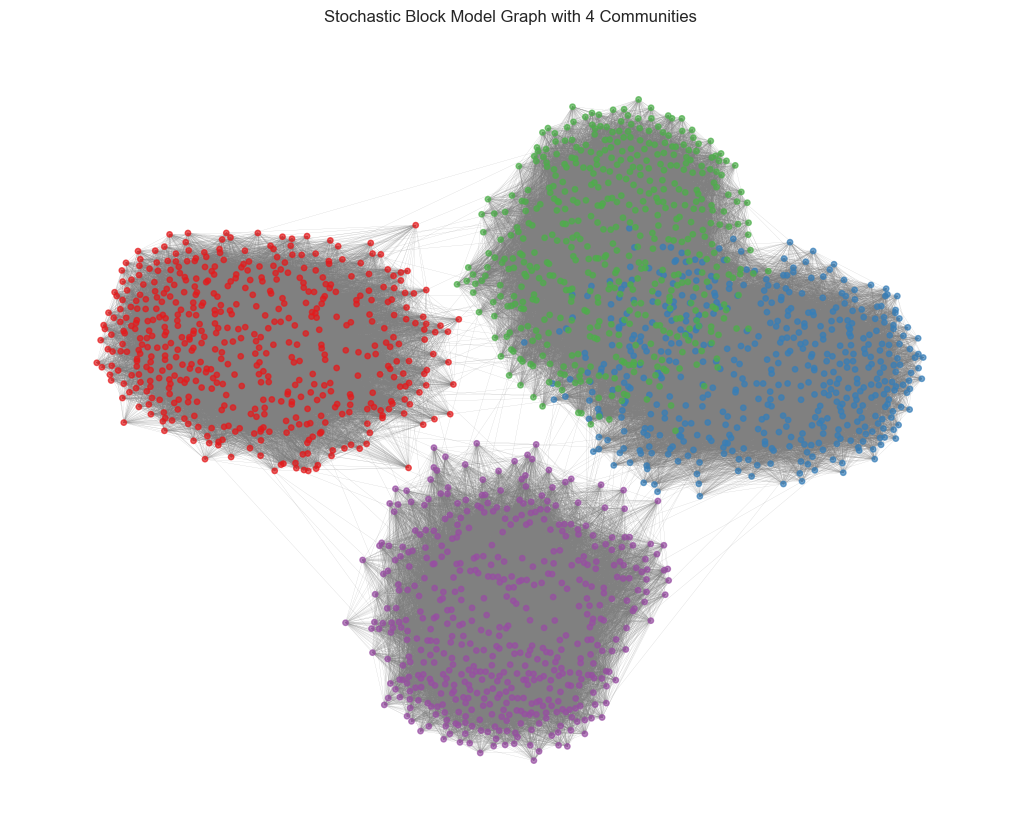

In [7]:
# Visualize the graph structure
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
node_colors = [colors[label] for label in node_labels]

plt.figure(figsize = (10, 8))
pos = nx.spring_layout(G, seed = 42, k = 0.5)
nx.draw(G, pos, node_color = node_colors, node_size = 15, 
        edge_color = 'gray', alpha = 0.7, width = 0.1)
plt.title("Stochastic Block Model Graph with 4 Communities")
plt.tight_layout()
plt.savefig("images/sbm_graph.png", dpi = 300)
plt.show()

In [8]:
# Create masks for 10 different runs
num_runs = 10
all_masks = []

for run in range(num_runs):
    train_mask, val_mask, test_mask = create_masks(
        custom_data.num_nodes, num_classes, seed = run
    )
    all_masks.append({
        'train': train_mask,
        'val': val_mask,
        'test': test_mask
    })
    
# Verify the first split
print(f"Run 0 - Train nodes: {all_masks[0]['train'].sum().item()}")
print(f"Run 0 - Val nodes: {all_masks[0]['val'].sum().item()}")
print(f"Run 0 - Test nodes: {all_masks[0]['test'].sum().item()}")

Run 0 - Train nodes: 1200
Run 0 - Val nodes: 400
Run 0 - Test nodes: 400


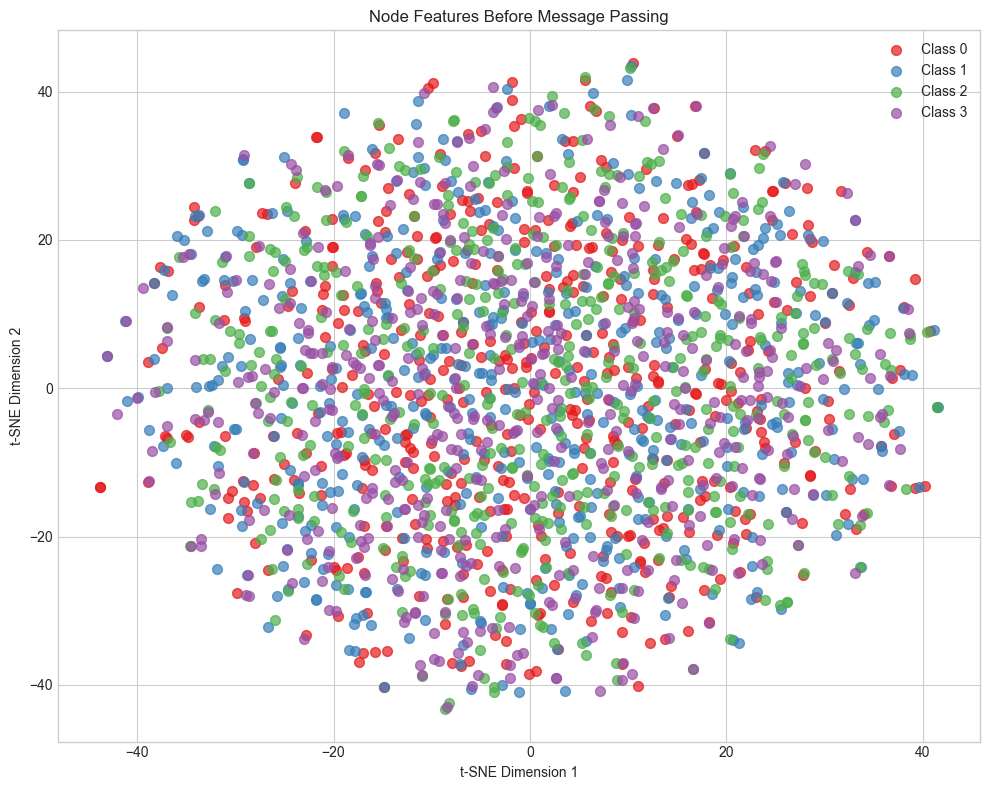

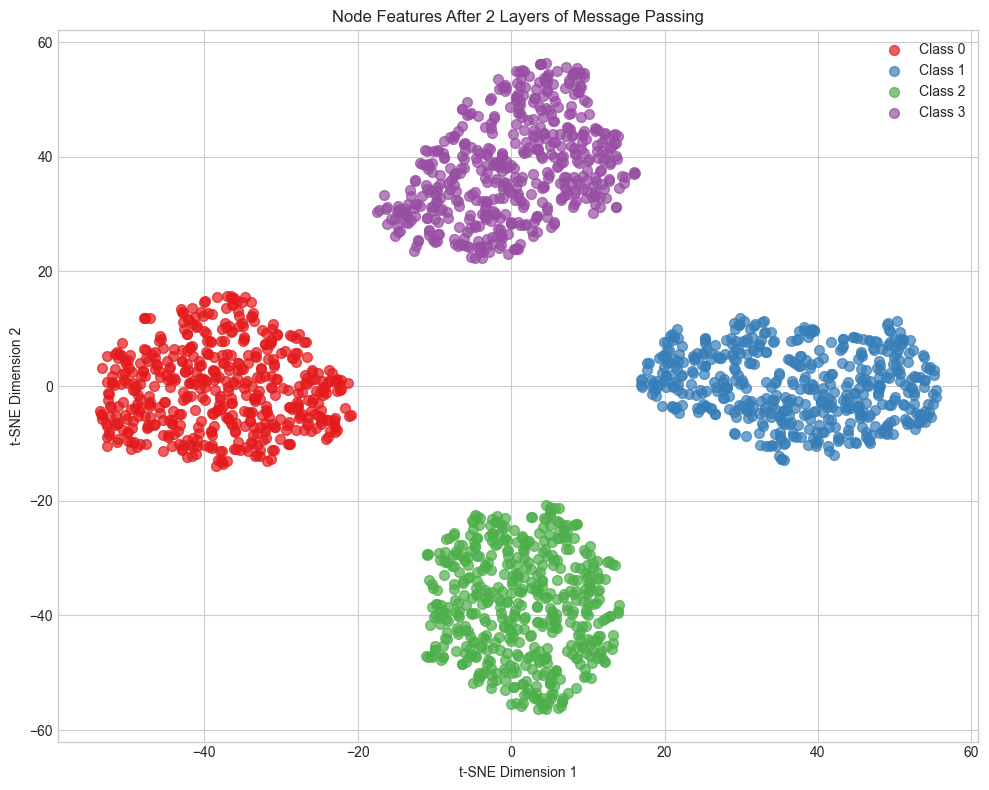

In [28]:
# Visualize the effect of message passing with t-SNE
# Before message passing

import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"
visualize_embeddings(
    custom_data.x, 
    custom_data.y.numpy(), 
    "Node Features Before Message Passing",
    "images/tsne_before_mp.png",
    num_classes = num_classes
)

# Apply multiple rounds of message passing
W1 = torch.randn(feature_dim, 32) * 0.1
W2 = torch.randn(32, 16) * 0.1

h1 = efficient_message_passing(custom_data.x, custom_data.edge_index, W1)
h2 = efficient_message_passing(h1, custom_data.edge_index, W2)

# After message passing
visualize_embeddings(
    h2,
    custom_data.y.numpy(),
    "Node Features After 2 Layers of Message Passing",
    "images/tsne_after_mp.png",
    num_classes = num_classes
)

*(Espacio para análisis del dataset sintético y efecto del message passing)*

---
## Ejercicio 2: Node Classification Experiments

### Part A: Custom Dataset

*(Espacio para texto descriptivo)*

In [10]:
# Train MLP and GCN on Custom Dataset across 10 runs
trainer_custom = GraphTrainer(
    num_epochs = 200,
    lr = 0.01,
    weight_decay = 5e-4,
    hidden_channels = 64,
    dropout = 0.5,
    optimizer_type = 'Adam'
)

trainer_custom.train(
    datasets = {'Custom': custom_data},
    model_classes = {'MLP': MLP, 'GCN': GCN},
    masks_dict = {'Custom': all_masks}
)

Training: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]


In [11]:
# Results summary — Custom Dataset
trainer_custom.get_results_df()

,Dataset,Model,Test Accuracy,Val Accuracy,Runs,Avg Epochs
0,Custom,GCN,0.9998 ± 0.0008,1.0000 ± 0.0000,10,25
1,Custom,MLP,0.2635 ± 0.0168,0.2975 ± 0.0143,10,37


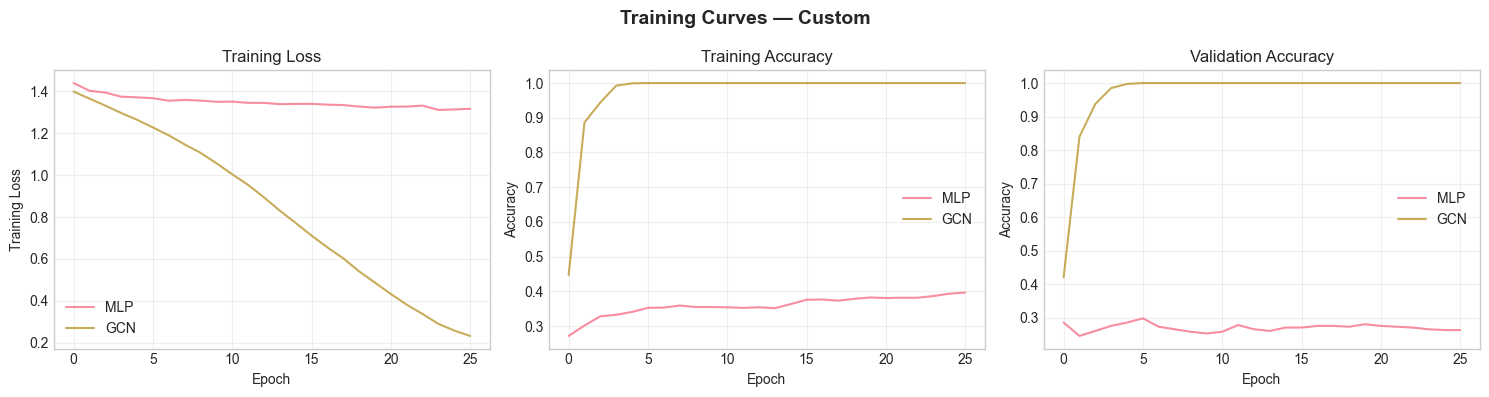

In [12]:
# Training curves — Custom Dataset (Run 0)
trainer_custom.plot_training_curves(dataset_name = 'Custom', run = 0, filename = 'images/training_curves_custom')

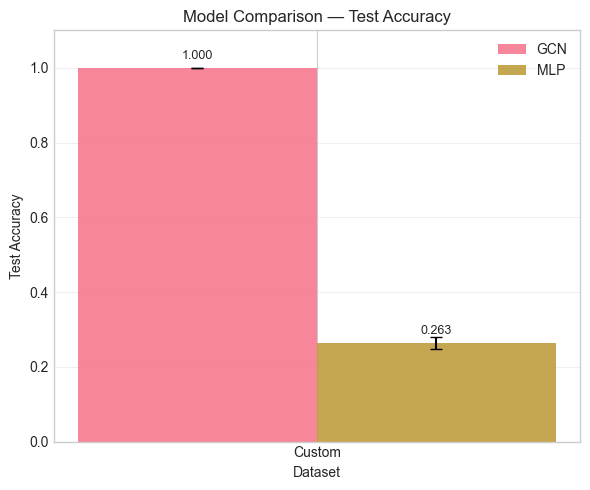

In [13]:
# Bar chart — Custom Dataset
trainer_custom.plot_bar_chart(filename = 'images/bar_chart_custom.png')

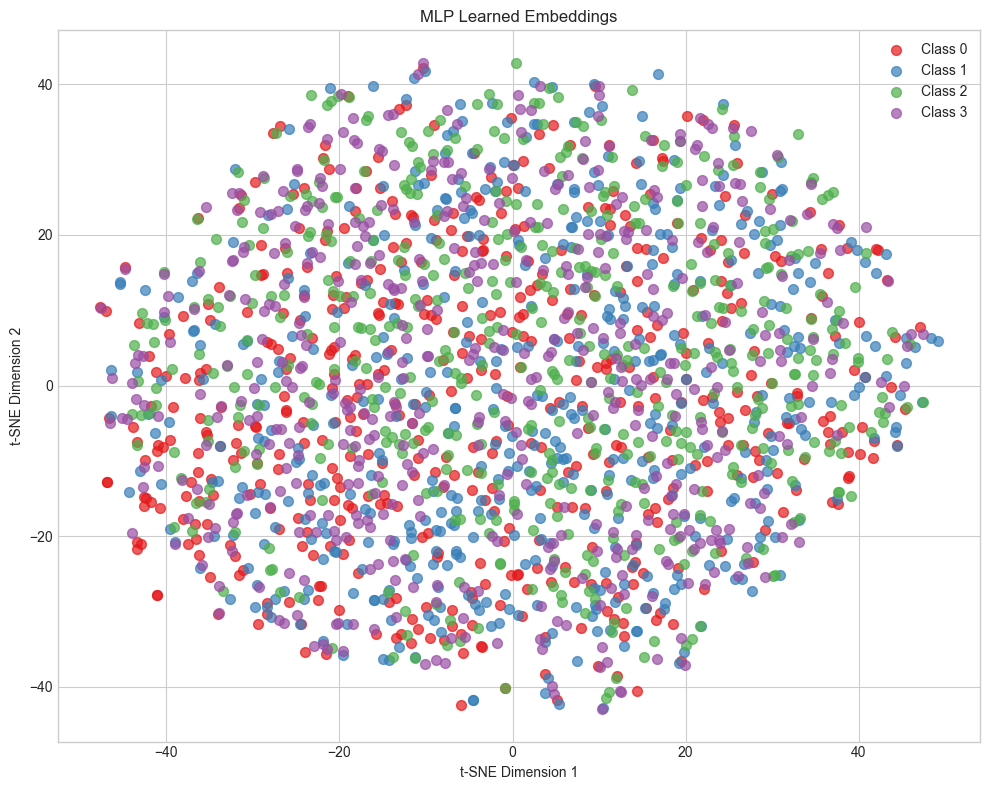

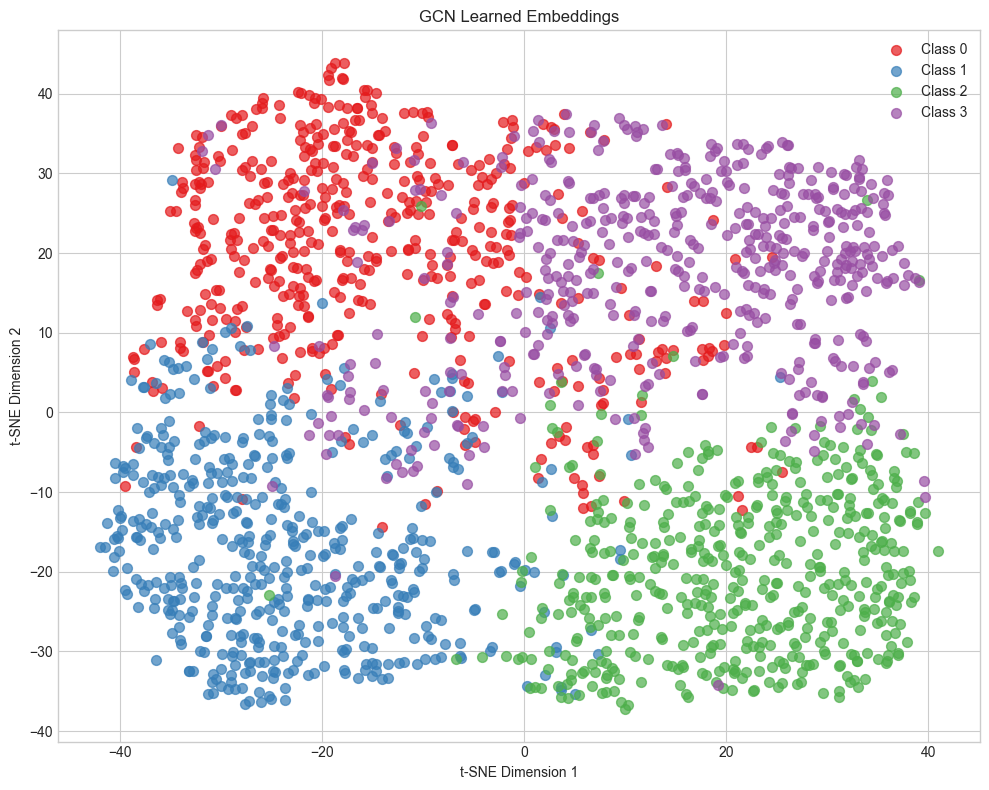

In [14]:
# t-SNE visualizations of learned embeddings — Custom Dataset
# Train fresh models for embedding extraction (using first run masks)
mlp_viz = MLP(custom_data.num_node_features, 64, num_classes)
gcn_viz = GCN(custom_data.num_node_features, 64, num_classes)

masks = all_masks[0]

# Use a temporary trainer to train the models for visualization
_trainer_viz = GraphTrainer(num_epochs = 200, lr = 0.01, weight_decay = 5e-4, hidden_channels = 64)
_trainer_viz._run_single(mlp_viz, custom_data, masks)
_trainer_viz._run_single(gcn_viz, custom_data, masks)

# Get and visualize embeddings
mlp_emb = get_embeddings(mlp_viz, custom_data)
gcn_emb = get_embeddings(gcn_viz, custom_data)

visualize_embeddings(
    mlp_emb,
    custom_data.y.numpy(),
    "MLP Learned Embeddings",
    "images/mlp_embeddings_custom.png",
    num_classes = num_classes
)

visualize_embeddings(
    gcn_emb,
    custom_data.y.numpy(),
    "GCN Learned Embeddings",
    "images/gcn_embeddings_custom.png",
    num_classes = num_classes
)

*(Espacio para análisis comparativo MLP vs GCN en Custom Dataset)*

### Part B: Benchmark Datasets (Cora & Citeseer)

*(Espacio para texto descriptivo)*

In [15]:
# Load the Cora dataset
cora_dataset = Planetoid(root = './data', name = 'Cora')
cora_data = cora_dataset[0]

print("Cora Dataset Statistics:")
print(f"  Number of nodes: {cora_data.num_nodes}")
print(f"  Number of edges: {cora_data.num_edges}")
print(f"  Number of features: {cora_data.num_node_features}")
print(f"  Number of classes: {cora_dataset.num_classes}")
print(f"  Has train/val/test masks: {hasattr(cora_data, 'train_mask')}")

# Load the Citeseer dataset
citeseer_dataset = Planetoid(root = './data', name = 'Citeseer')
citeseer_data = citeseer_dataset[0]

print("\nCiteseer Dataset Statistics:")
print(f"  Number of nodes: {citeseer_data.num_nodes}")
print(f"  Number of edges: {citeseer_data.num_edges}")
print(f"  Number of features: {citeseer_data.num_node_features}")
print(f"  Number of classes: {citeseer_dataset.num_classes}")

Cora Dataset Statistics:
  Number of nodes: 2708
  Number of edges: 10556
  Number of features: 1433
  Number of classes: 7
  Has train/val/test masks: True

Citeseer Dataset Statistics:
  Number of nodes: 3327
  Number of edges: 9104
  Number of features: 3703
  Number of classes: 6


In [16]:
# Train MLP and GCN on Cora and Citeseer (using built-in train/val/test masks)
trainer_bench = GraphTrainer(
    num_epochs = 200,
    lr = 0.01,
    weight_decay = 5e-4,
    hidden_channels = 64,
    dropout = 0.5,
    optimizer_type = 'Adam'
)

trainer_bench.train(
    datasets = {'Cora': cora_data, 'Citeseer': citeseer_data},
    model_classes = {'MLP': MLP, 'GCN': GCN},
    masks_dict = None  # Uses built-in masks (single run)
)

Training: 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


In [17]:
# Results summary — Benchmark Datasets
trainer_bench.get_results_df()

,Dataset,Model,Test Accuracy,Val Accuracy,Runs,Avg Epochs
0,Citeseer,GCN,0.6870,0.6720,1,27
1,Citeseer,MLP,0.5230,0.5300,1,26
2,Cora,GCN,0.8080,0.7960,1,27
3,Cora,MLP,0.5730,0.5880,1,33


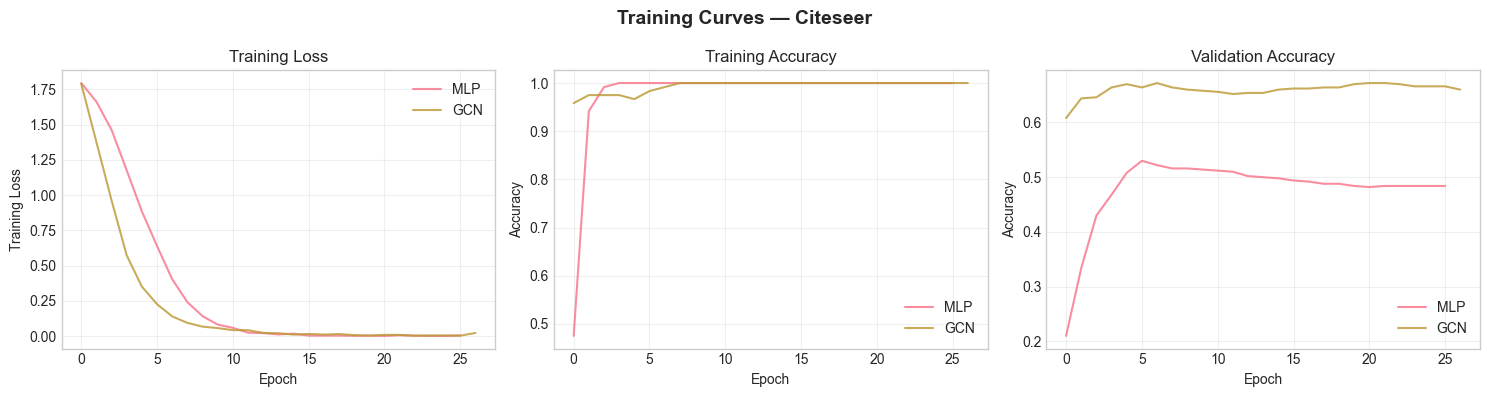

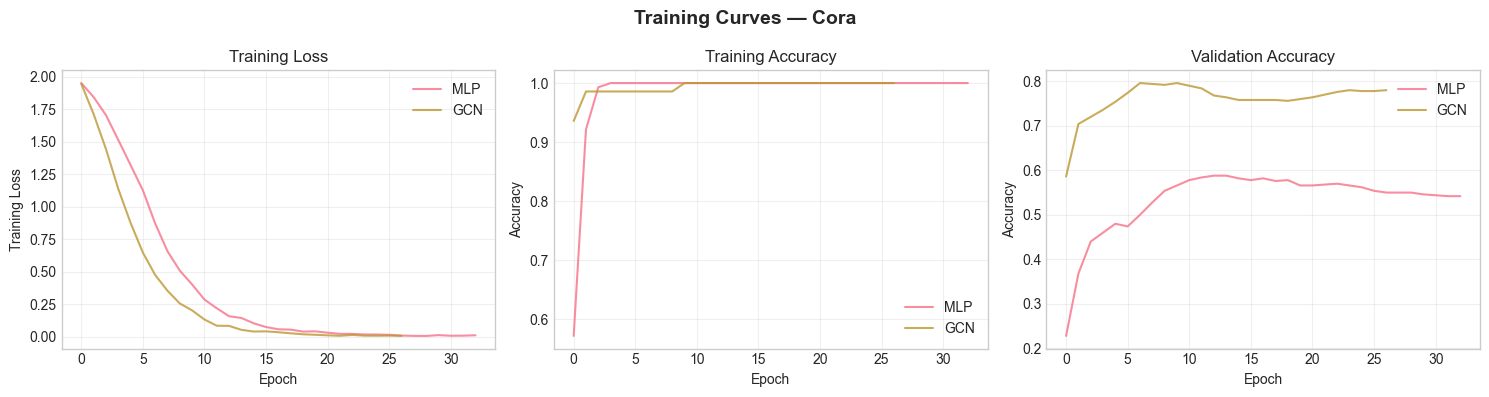

In [18]:
# Training curves — Benchmark Datasets
trainer_bench.plot_training_curves(filename = 'images/training_curves_bench')

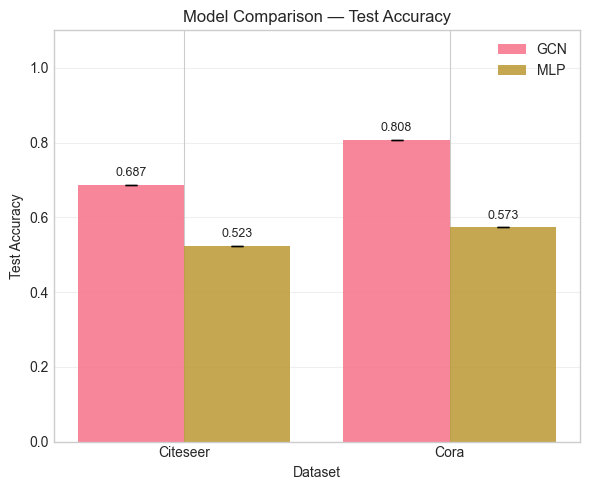

In [19]:
# Bar chart — Benchmark Datasets
trainer_bench.plot_bar_chart(filename = 'images/bar_chart_bench.png')

*(Espacio para análisis de los resultados en Benchmark Datasets)*

### Exploración de Hiperparámetros

*(Espacio para texto descriptivo sobre la metodología de exploración de hiperparámetros)*

In [20]:
# Prepare datasets for multi-dataset experimentation
datasets_exp = {
    'Custom': custom_data,
    'Cora': cora_data,
    'Citeseer': citeseer_data
}

# Create masks for Cora and Citeseer (for multiple runs)
n_runs_exp = 5
exp_masks = {}

exp_masks['Custom'] = all_masks[:n_runs_exp]

cora_masks = []
for run in range(n_runs_exp):
    tm, vm, tem = create_masks(cora_data.num_nodes, cora_dataset.num_classes, seed = run)
    cora_masks.append({'train': tm, 'val': vm, 'test': tem})
exp_masks['Cora'] = cora_masks

citeseer_masks = []
for run in range(n_runs_exp):
    tm, vm, tem = create_masks(citeseer_data.num_nodes, citeseer_dataset.num_classes, seed = run)
    citeseer_masks.append({'train': tm, 'val': vm, 'test': tem})
exp_masks['Citeseer'] = citeseer_masks

# Base hyperparameters (varied one at a time)
base_config = {
    'num_epochs': 200,
    'lr': 0.01,
    'weight_decay': 5e-4,
    'hidden_channels': 64,
    'dropout': 0.5,
    'optimizer_type': 'Adam',
    'patience': 20
}

print(f"Datasets: {list(datasets_exp.keys())}")
print(f"Runs per config: {n_runs_exp}")
print(f"Base config: {base_config}")
print(f"Device: {device}")

Datasets: ['Custom', 'Cora', 'Citeseer']
Runs per config: 5
Base config: {'num_epochs': 200, 'lr': 0.01, 'weight_decay': 0.0005, 'hidden_channels': 64, 'dropout': 0.5, 'optimizer_type': 'Adam', 'patience': 20}
Device: cuda


In [21]:
# Helper function to run a hyperparameter sweep and return a summary DataFrame + trainers
def run_hyperparam_sweep(param_name, param_values, base_config, datasets_exp, exp_masks):
    """
    Sweep one hyperparameter while keeping the rest at base values.
    Returns (DataFrame, dict of trainers keyed by param value).
    """
    all_rows = []
    trainers = {}
    
    for val in tqdm(param_values, desc = f'Sweep {param_name}'):
        # Override the swept param
        config = base_config.copy()
        config[param_name] = val
        
        trainer = GraphTrainer(
            num_epochs = config['num_epochs'],
            lr = config['lr'],
            weight_decay = config['weight_decay'],
            hidden_channels = config['hidden_channels'],
            dropout = config['dropout'],
            optimizer_type = config['optimizer_type'],
            patience = config.get('patience', 20)
        )
        
        trainer.train(
            datasets = datasets_exp,
            model_classes = {'MLP': MLP, 'GCN': GCN},
            masks_dict = exp_masks
        )
        
        trainers[val] = trainer
        
        # Extract per-dataset/model results
        df = pd.DataFrame(trainer._results)
        summary = df.groupby(['Dataset', 'Model']).agg(
            mean = ('Best Test Acc', 'mean'),
            std  = ('Best Test Acc', 'std'),
            avg_epochs = ('Epochs Trained', 'mean')
        ).reset_index()
        summary['std'] = summary['std'].fillna(0)
        summary[param_name] = val
        all_rows.append(summary)
    
    return pd.concat(all_rows, ignore_index = True), trainers


def plot_hyperparam_sweep(sweep_df, param_name, param_values, title, filename = None):
    """
    Plot a multi-dataset hyperparameter sweep with subplots.
    """
    datasets = sweep_df['Dataset'].unique()
    fig, axes = plt.subplots(1, len(datasets), figsize = (6 * len(datasets), 5), sharey = True)
    if len(datasets) == 1:
        axes = [axes]
    
    x = np.arange(len(param_values))
    
    for idx, (ds_name, ax) in enumerate(zip(datasets, axes)):
        ds_data = sweep_df[sweep_df['Dataset'] == ds_name]
        
        for model_name, color, marker in [('MLP', '#e74c3c', 'o'), ('GCN', '#3498db', 's')]:
            model_data = ds_data[ds_data['Model'] == model_name]
            means = [model_data[model_data[param_name] == v]['mean'].values[0] for v in param_values]
            stds  = [model_data[model_data[param_name] == v]['std'].values[0] for v in param_values]
            ax.errorbar(x, means, yerr = stds, fmt = f'-{marker}', label = model_name,
                       color = color, capsize = 5, linewidth = 2)
        
        ax.set_xlabel(param_name, fontsize = 12)
        if idx == 0:
            ax.set_ylabel('Test Accuracy', fontsize = 12)
        ax.set_title(f'Dataset: {ds_name}', fontsize = 14, fontweight = 'bold')
        ax.set_xticks(x)
        ax.set_xticklabels([str(v) for v in param_values], rotation = 45)
        ax.legend()
        ax.grid(True, alpha = 0.3)
        ax.set_ylim([0, 1.05])
    
    plt.suptitle(title, fontsize = 16, y = 1.05)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi = 150, bbox_inches = 'tight')
    plt.show()


def display_sweep_table(sweep_df, param_name, display_name = None):
    """
    Format and display a sweep DataFrame as a clean table.
    """
    display_name = display_name or param_name
    df_display = sweep_df.copy()
    df_display['Accuracy'] = df_display.apply(lambda r: f"{r['mean']:.4f} ± {r['std']:.4f}", axis = 1)
    df_display['Avg Epochs'] = df_display['avg_epochs'].apply(lambda x: f"{x:.0f}")
    result = df_display[[param_name, 'Dataset', 'Model', 'Accuracy', 'Avg Epochs']].rename(
        columns = {param_name: display_name}
    )
    display(result)

#### Experimento: Dimensiones de la capa oculta

Sweep hidden_channels: 100%|██████████| 4/4 [00:25<00:00,  6.49s/it]


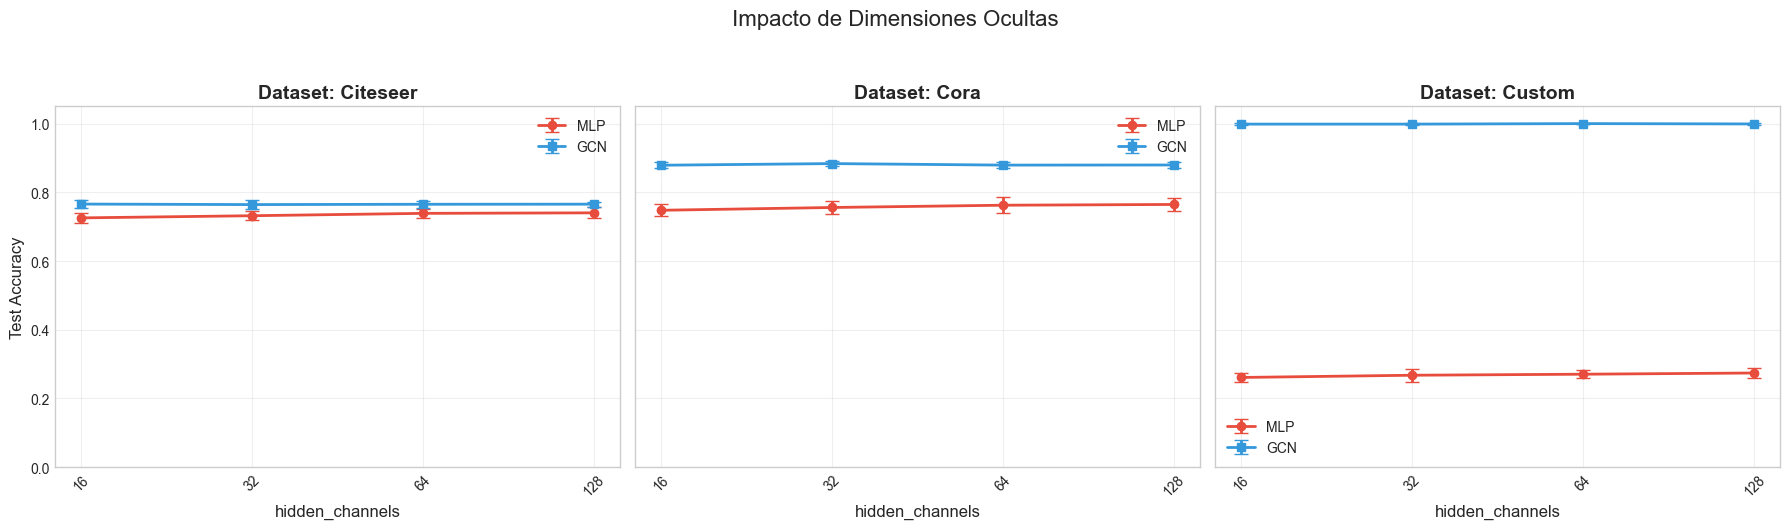

,Hidden Channels,Dataset,Model,Accuracy,Avg Epochs
0,16,Citeseer,GCN,0.7658 ± 0.0128,38
1,16,Citeseer,MLP,0.7255 ± 0.0139,44
2,16,Cora,GCN,0.8788 ± 0.0093,48
3,16,Cora,MLP,0.7477 ± 0.0174,78
4,16,Custom,GCN,0.9985 ± 0.0034,41
5,16,Custom,MLP,0.2610 ± 0.0119,43
6,32,Citeseer,GCN,0.7643 ± 0.0123,30
7,32,Citeseer,MLP,0.7318 ± 0.0130,32
8,32,Cora,GCN,0.8836 ± 0.0062,44
9,32,Cora,MLP,0.7558 ± 0.0187,57



— Curvas de entrenamiento para hidden_channels = 128 —


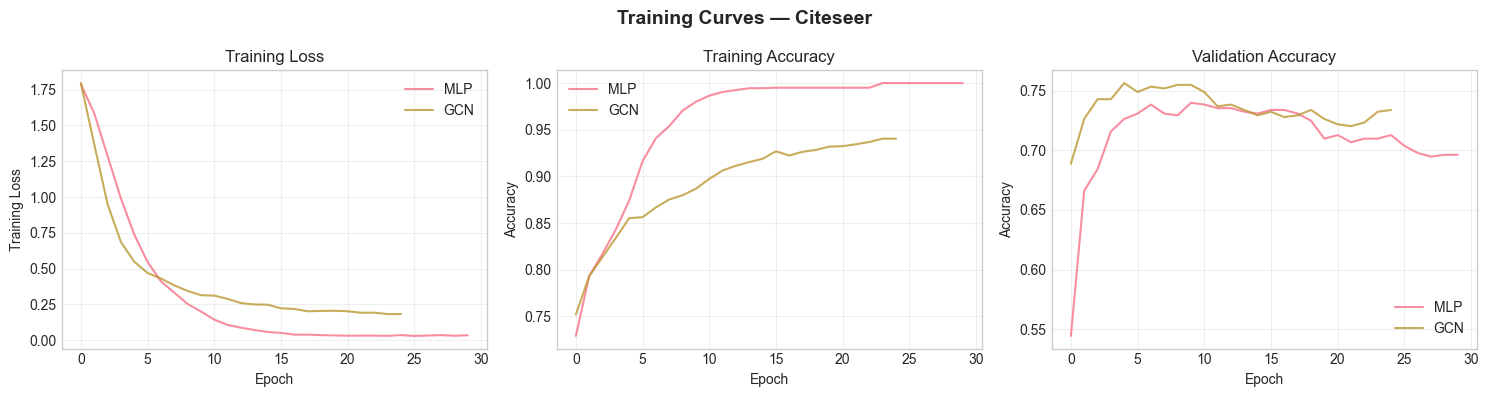

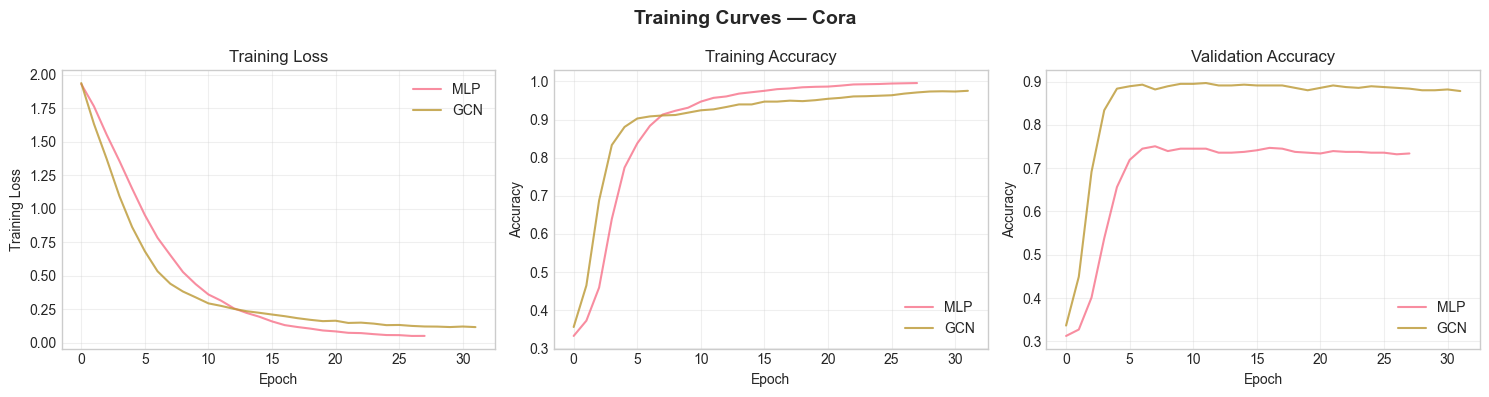

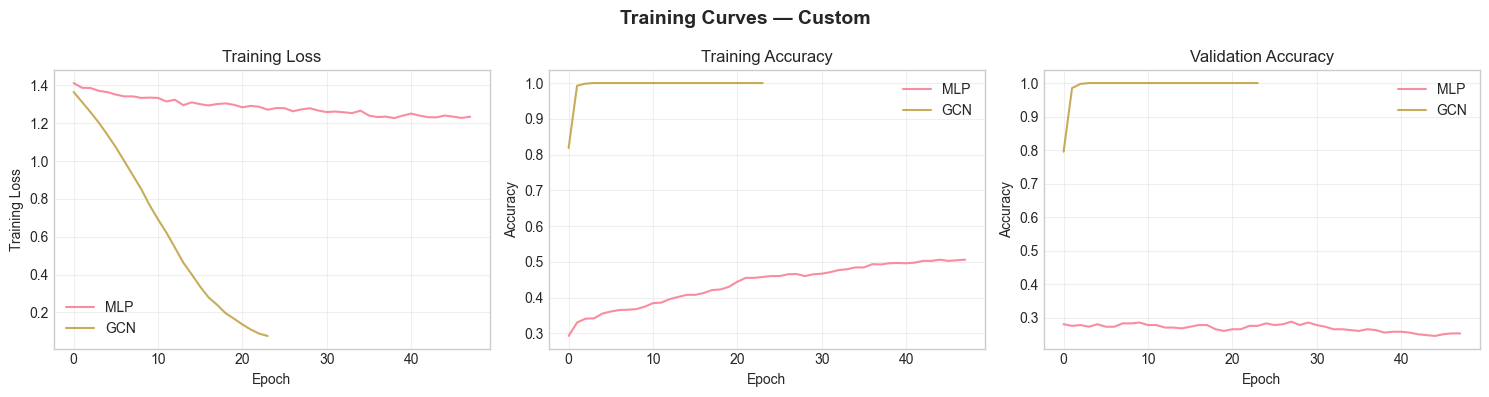

In [22]:
# Experiment: Hidden Dimensions
hidden_dims = [16, 32, 64, 128]
sweep_hidden, trainers_hidden = run_hyperparam_sweep('hidden_channels', hidden_dims, base_config, datasets_exp, exp_masks)
plot_hyperparam_sweep(sweep_hidden, 'hidden_channels', hidden_dims,
                      'Impacto de Dimensiones Ocultas', 'images/exp_hidden_dims.png')

# Summary table
display_sweep_table(sweep_hidden, 'hidden_channels', 'Hidden Channels')

# Training curves for hidden_channels = 128
print("\n— Curvas de entrenamiento para hidden_channels = 128 —")
trainers_hidden[128].plot_training_curves(run = 0, filename = 'images/curves_hidden128')

*(Espacio para análisis de dimensiones ocultas)*

#### Experimento: Learning Rate

Sweep lr: 100%|██████████| 3/3 [00:24<00:00,  8.18s/it]


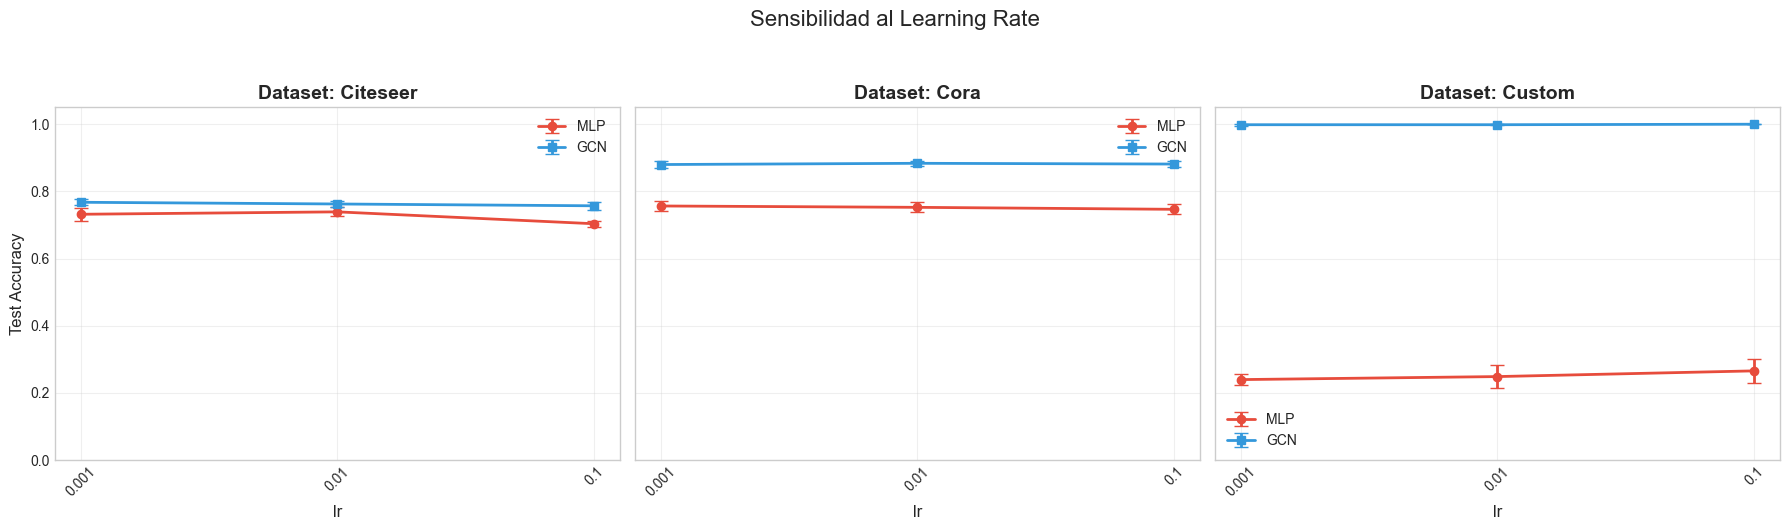

,Learning Rate,Dataset,Model,Accuracy,Avg Epochs
0,0.001,Citeseer,GCN,0.7676 ± 0.0096,66
1,0.001,Citeseer,MLP,0.7318 ± 0.0189,82
2,0.001,Cora,GCN,0.8799 ± 0.0097,98
3,0.001,Cora,MLP,0.7565 ± 0.0160,116
4,0.001,Custom,GCN,0.9985 ± 0.0034,49
5,0.001,Custom,MLP,0.2395 ± 0.0164,43
6,0.010,Citeseer,GCN,0.7625 ± 0.0084,28
7,0.010,Citeseer,MLP,0.7390 ± 0.0136,29
8,0.010,Cora,GCN,0.8836 ± 0.0074,39
9,0.010,Cora,MLP,0.7525 ± 0.0151,38



— Curvas de entrenamiento para lr = 0.01 —


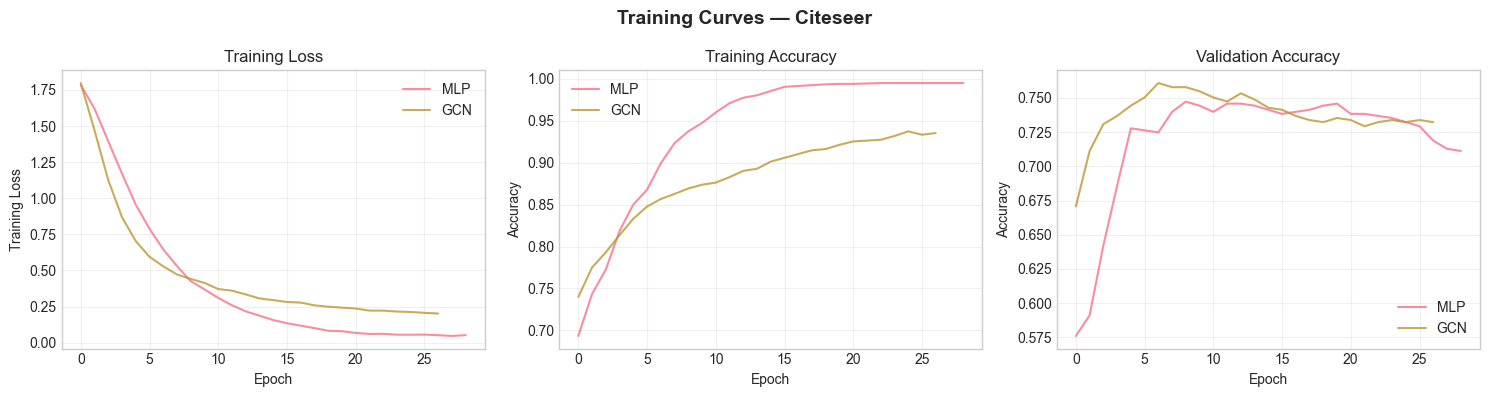

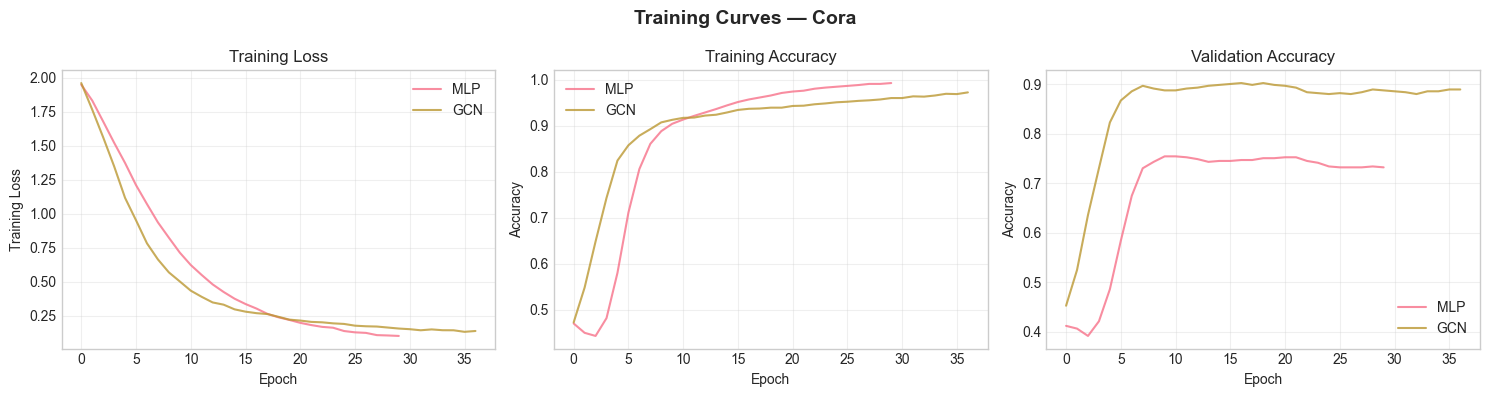

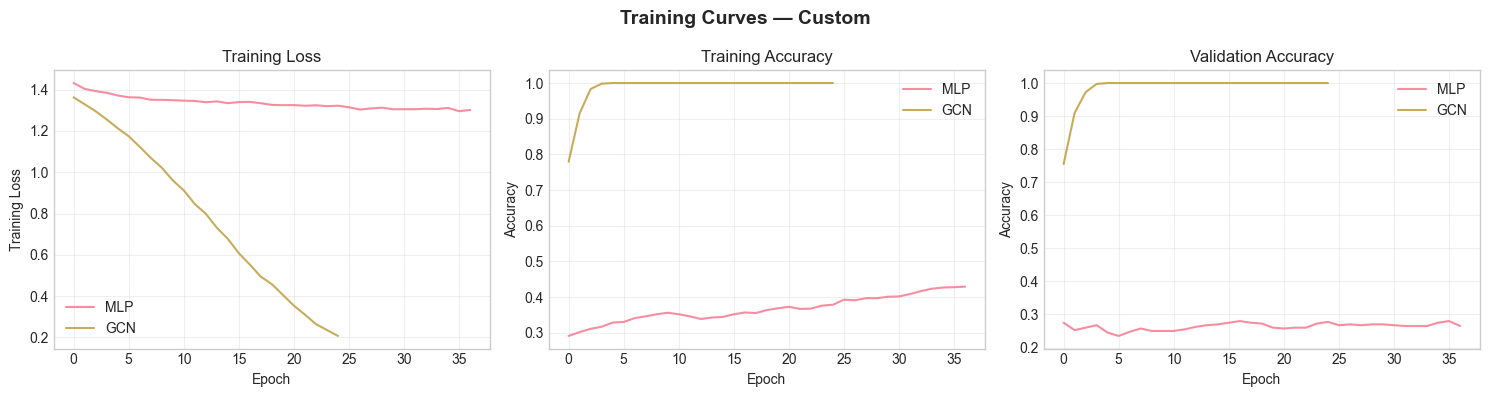

In [23]:
# Experiment: Learning Rate
learning_rates = [0.001, 0.01, 0.1]
sweep_lr, trainers_lr = run_hyperparam_sweep('lr', learning_rates, base_config, datasets_exp, exp_masks)
plot_hyperparam_sweep(sweep_lr, 'lr', learning_rates,
                      'Sensibilidad al Learning Rate', 'images/exp_learning_rate.png')

# Summary table
display_sweep_table(sweep_lr, 'lr', 'Learning Rate')

# Training curves for lr = 0.01
print("\n— Curvas de entrenamiento para lr = 0.01 —")
trainers_lr[0.01].plot_training_curves(run = 0, filename = 'images/curves_lr001')

*(Espacio para análisis de learning rate)*

#### Experimento: Dropout

Sweep dropout: 100%|██████████| 3/3 [00:17<00:00,  5.93s/it]


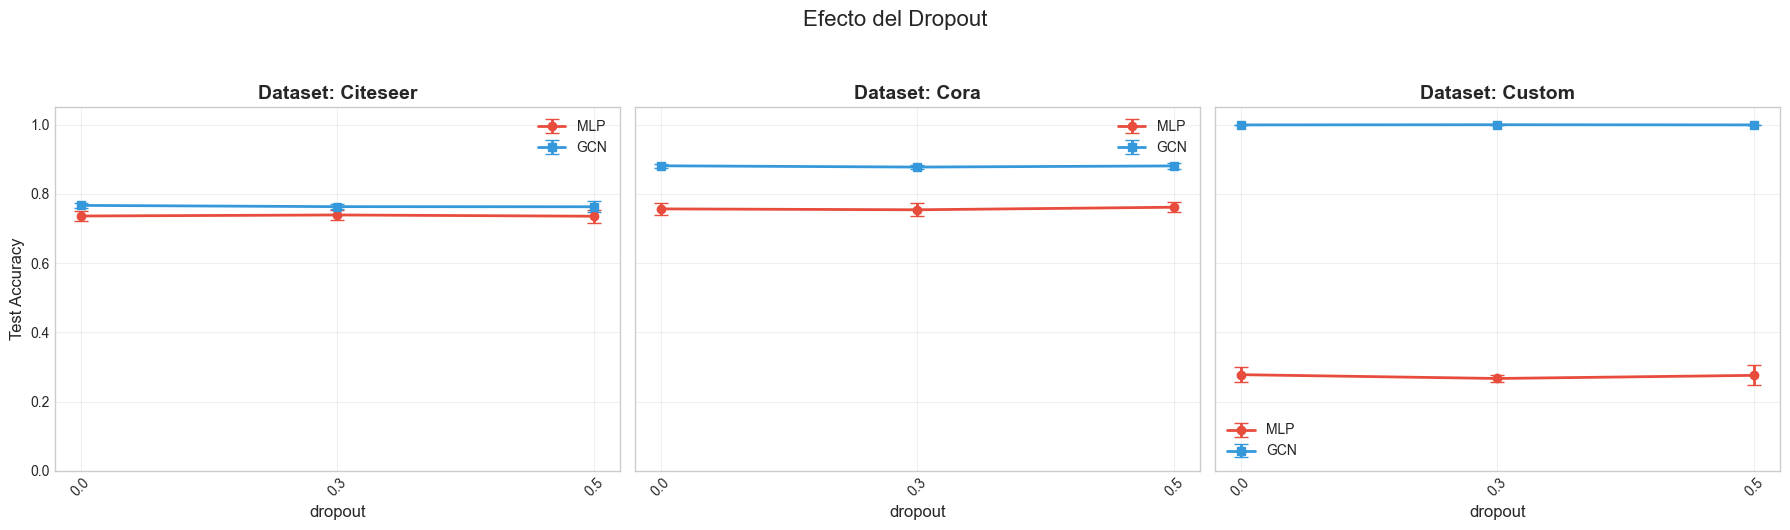

,Dropout Rate,Dataset,Model,Accuracy,Avg Epochs
0,0.0,Citeseer,GCN,0.7670 ± 0.0081,28
1,0.0,Citeseer,MLP,0.7363 ± 0.0141,29
2,0.0,Cora,GCN,0.8814 ± 0.0062,43
3,0.0,Cora,MLP,0.7569 ± 0.0163,38
4,0.0,Custom,GCN,0.9995 ± 0.0011,26
5,0.0,Custom,MLP,0.2780 ± 0.0212,32
6,0.3,Citeseer,GCN,0.7634 ± 0.0075,29
7,0.3,Citeseer,MLP,0.7393 ± 0.0131,29
8,0.3,Cora,GCN,0.8777 ± 0.0055,41
9,0.3,Cora,MLP,0.7543 ± 0.0192,38



— Curvas de entrenamiento para dropout = 0.3 —


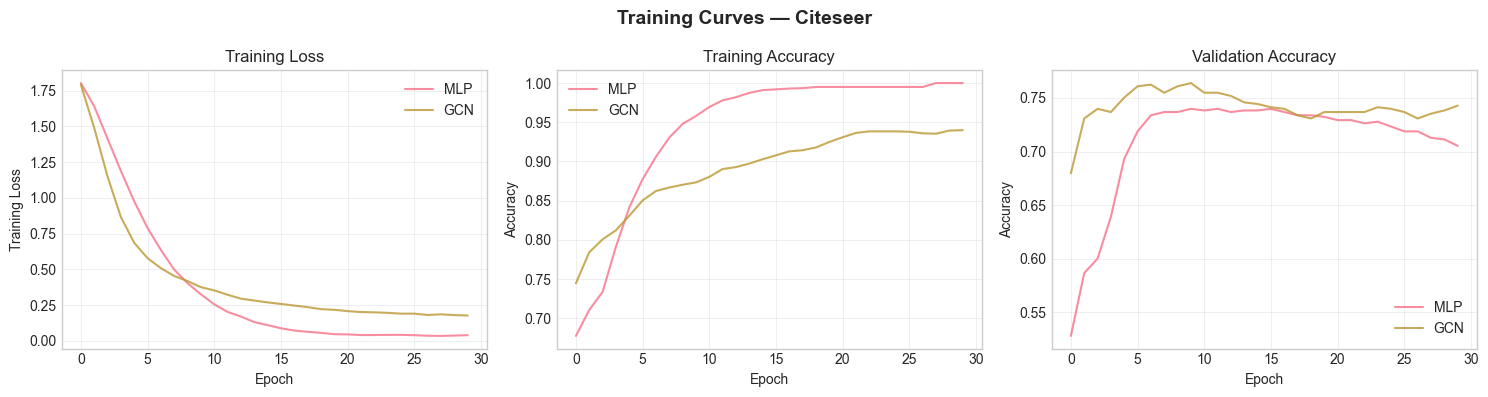

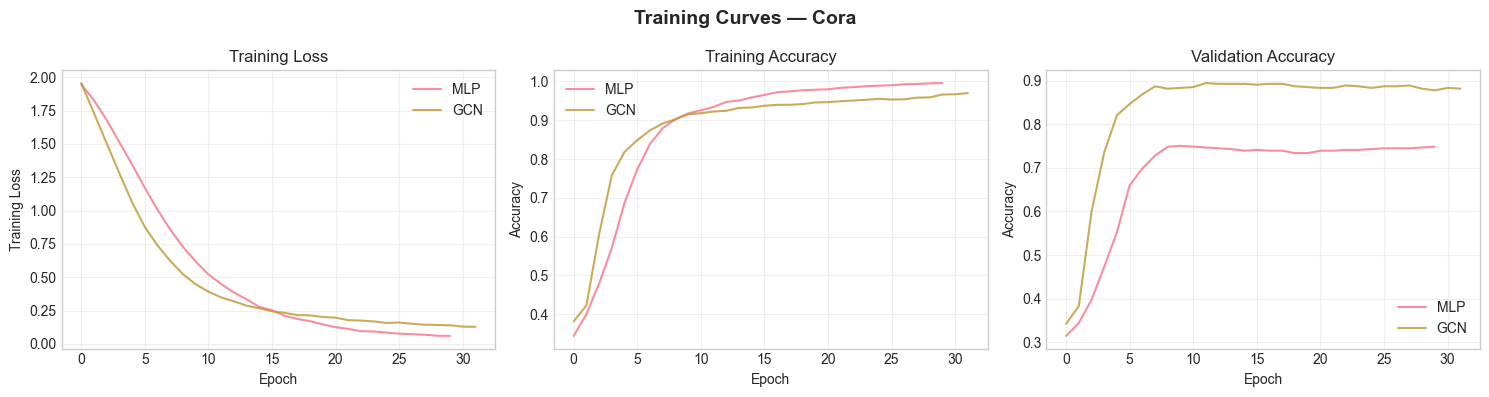

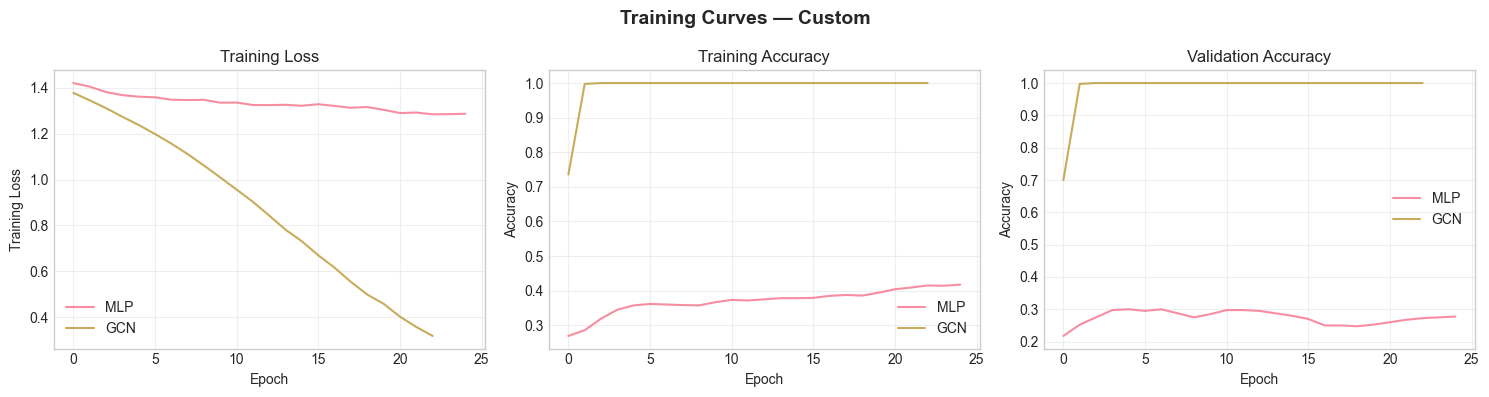

In [24]:
# Experiment: Dropout
dropout_rates = [0.0, 0.3, 0.5]
sweep_dropout, trainers_dropout = run_hyperparam_sweep('dropout', dropout_rates, base_config, datasets_exp, exp_masks)
plot_hyperparam_sweep(sweep_dropout, 'dropout', dropout_rates,
                      'Efecto del Dropout', 'images/exp_dropout.png')

# Summary table
display_sweep_table(sweep_dropout, 'dropout', 'Dropout Rate')

# Training curves for dropout = 0.3
print("\n— Curvas de entrenamiento para dropout = 0.3 —")
trainers_dropout[0.3].plot_training_curves(run = 0, filename = 'images/curves_dropout03')

*(Espacio para análisis de dropout)*

#### Experimento: Weight Decay

Sweep weight_decay: 100%|██████████| 3/3 [00:18<00:00,  6.01s/it]


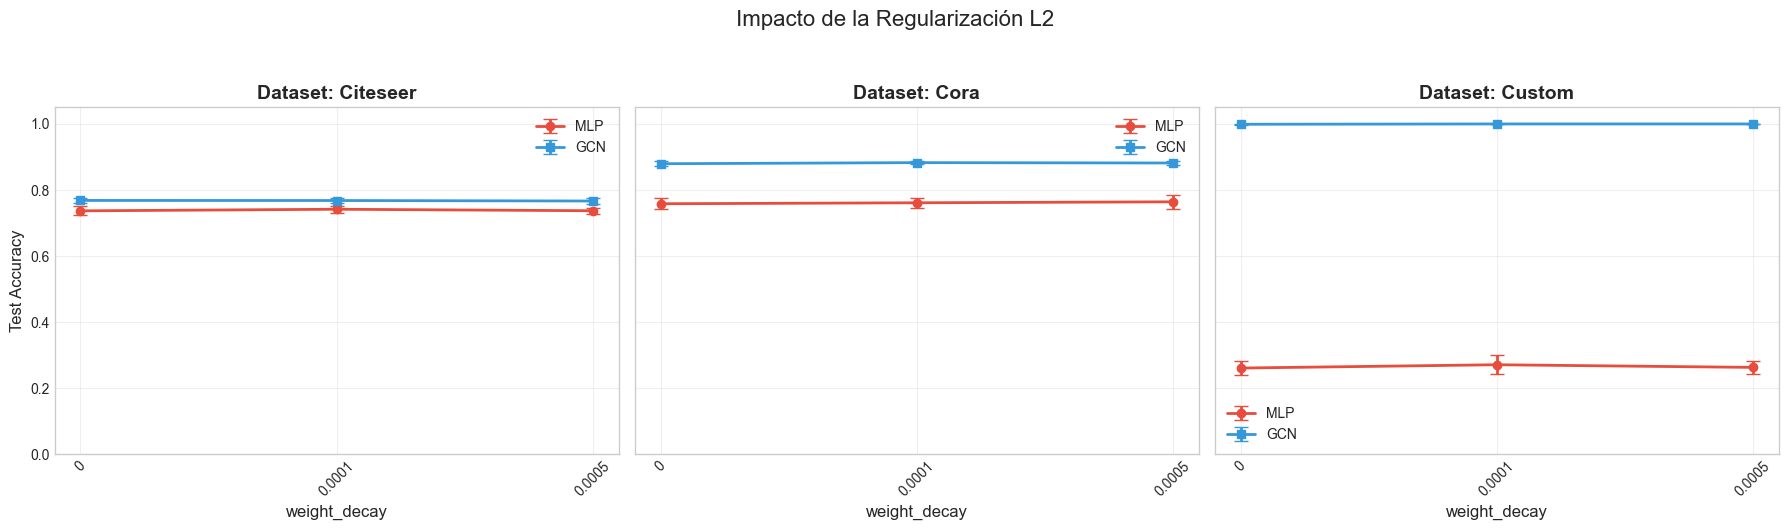

,Weight Decay,Dataset,Model,Accuracy,Avg Epochs
0,0.0000,Citeseer,GCN,0.7685 ± 0.0081,28
1,0.0000,Citeseer,MLP,0.7369 ± 0.0131,31
2,0.0000,Cora,GCN,0.8796 ± 0.0072,34
3,0.0000,Cora,MLP,0.7584 ± 0.0159,37
4,0.0000,Custom,GCN,0.9990 ± 0.0014,24
5,0.0000,Custom,MLP,0.2610 ± 0.0223,34
6,0.0001,Citeseer,GCN,0.7682 ± 0.0085,29
7,0.0001,Citeseer,MLP,0.7417 ± 0.0113,28
8,0.0001,Cora,GCN,0.8829 ± 0.0048,39
9,0.0001,Cora,MLP,0.7613 ± 0.0160,40



— Curvas de entrenamiento para weight_decay = 1e-4 —


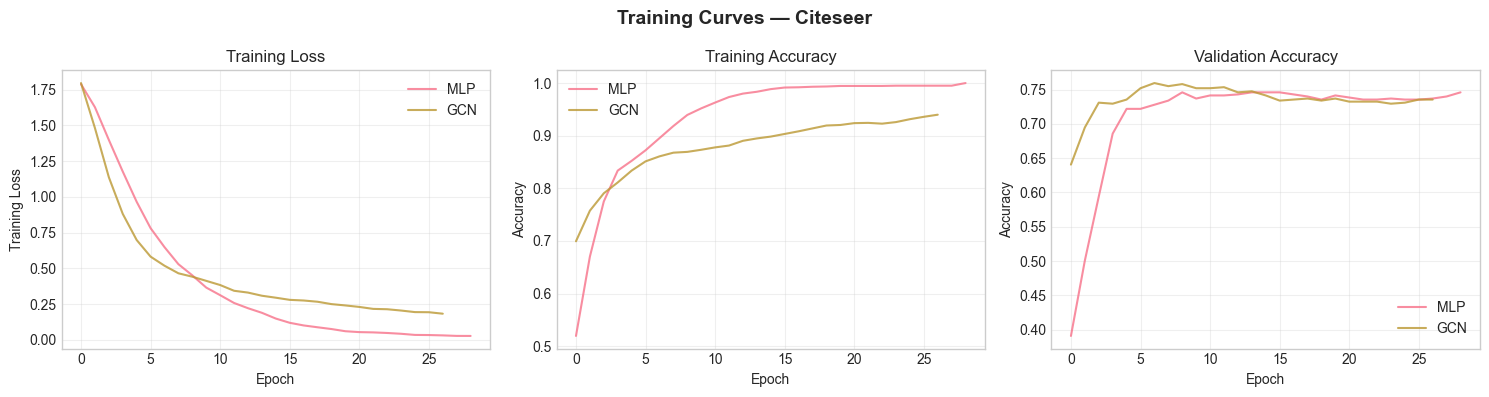

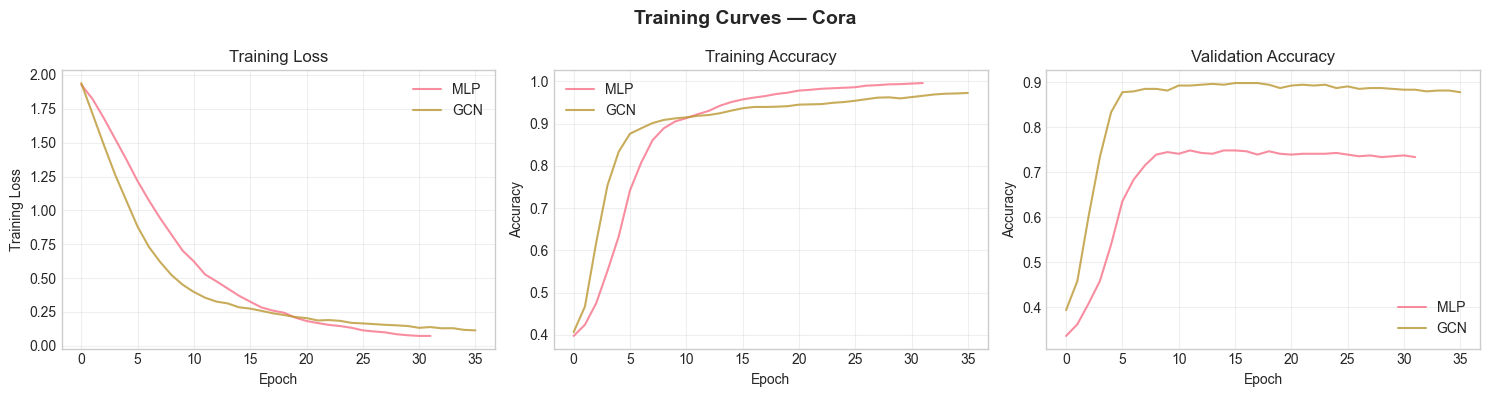

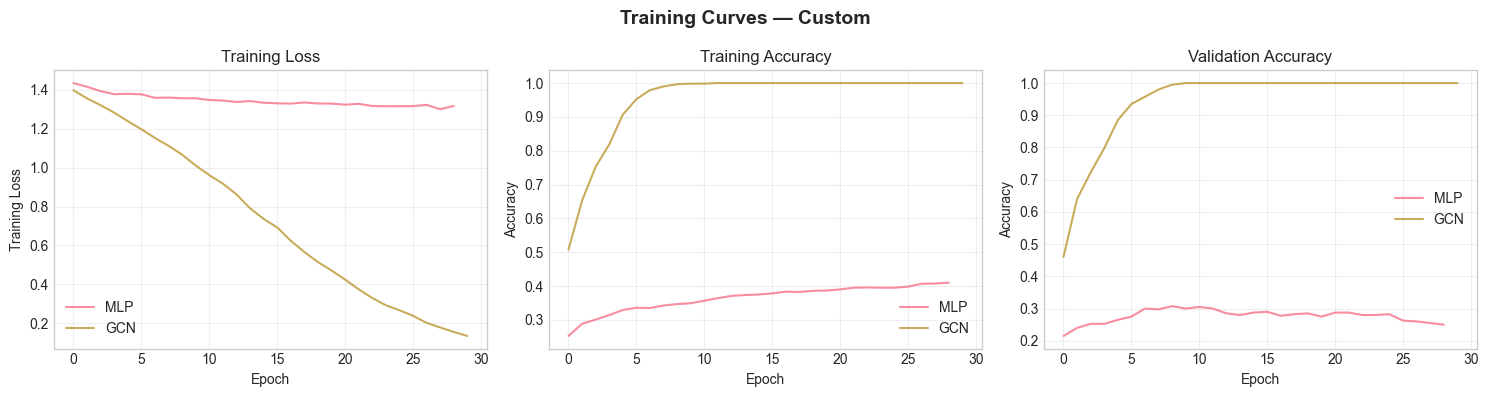

In [25]:
# Experiment: Weight Decay
weight_decays = [0, 1e-4, 5e-4]
sweep_wd, trainers_wd = run_hyperparam_sweep('weight_decay', weight_decays, base_config, datasets_exp, exp_masks)
plot_hyperparam_sweep(sweep_wd, 'weight_decay', weight_decays,
                      'Impacto de la Regularización L2', 'images/exp_weight_decay.png')

# Summary table
display_sweep_table(sweep_wd, 'weight_decay', 'Weight Decay')

# Training curves for weight_decay = 1e-4
print("\n— Curvas de entrenamiento para weight_decay = 1e-4 —")
trainers_wd[1e-4].plot_training_curves(run = 0, filename = 'images/curves_wd1e4')

*(Espacio para análisis de weight decay)*

#### Experimento: Optimizador (Adam vs SGD)

Sweep optimizer_type: 100%|██████████| 2/2 [00:23<00:00, 11.50s/it]


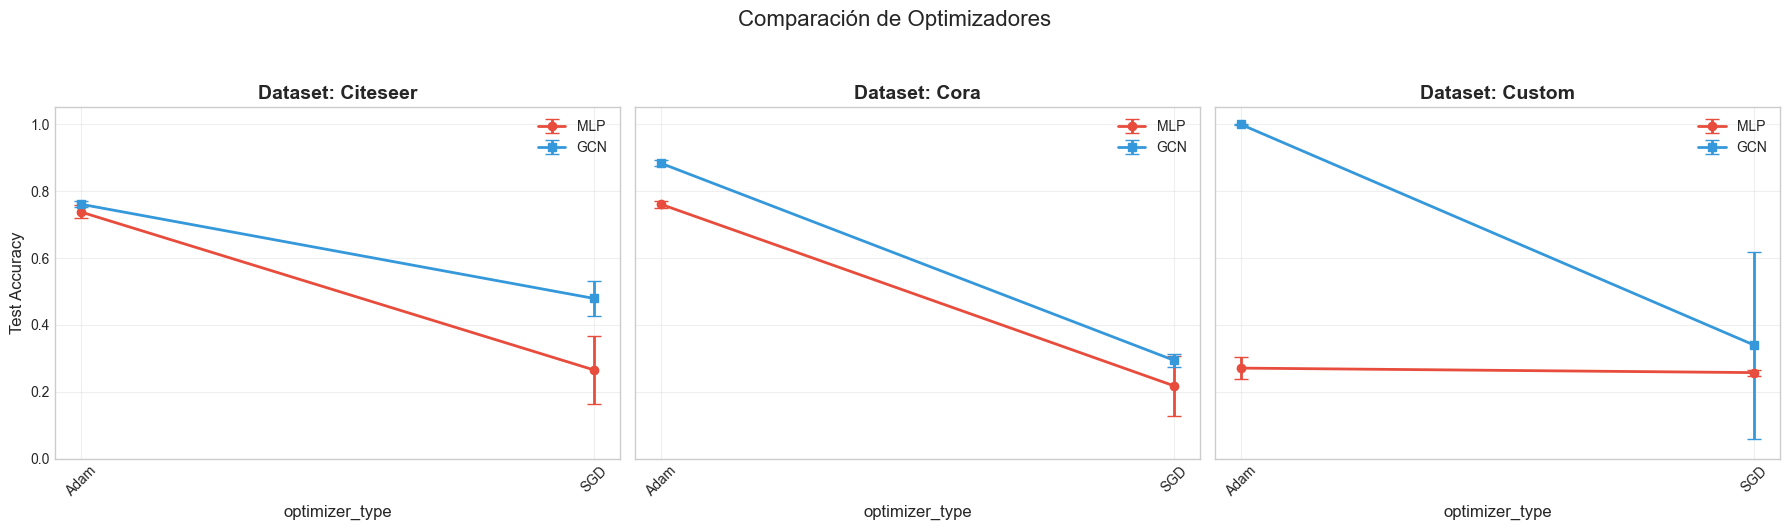

,Optimizer,Dataset,Model,Accuracy,Avg Epochs
0,Adam,Citeseer,GCN,0.7610 ± 0.0081,29
1,Adam,Citeseer,MLP,0.7378 ± 0.0194,30
2,Adam,Cora,GCN,0.8836 ± 0.0100,37
3,Adam,Cora,MLP,0.7610 ± 0.0102,35
4,Adam,Custom,GCN,0.9995 ± 0.0011,25
5,Adam,Custom,MLP,0.2710 ± 0.0330,31
6,SGD,Citeseer,GCN,0.4790 ± 0.0515,200
7,SGD,Citeseer,MLP,0.2652 ± 0.1014,105
8,SGD,Cora,GCN,0.2939 ± 0.0204,67
9,SGD,Cora,MLP,0.2177 ± 0.0898,46



— Curvas de entrenamiento para optimizer = SGD —


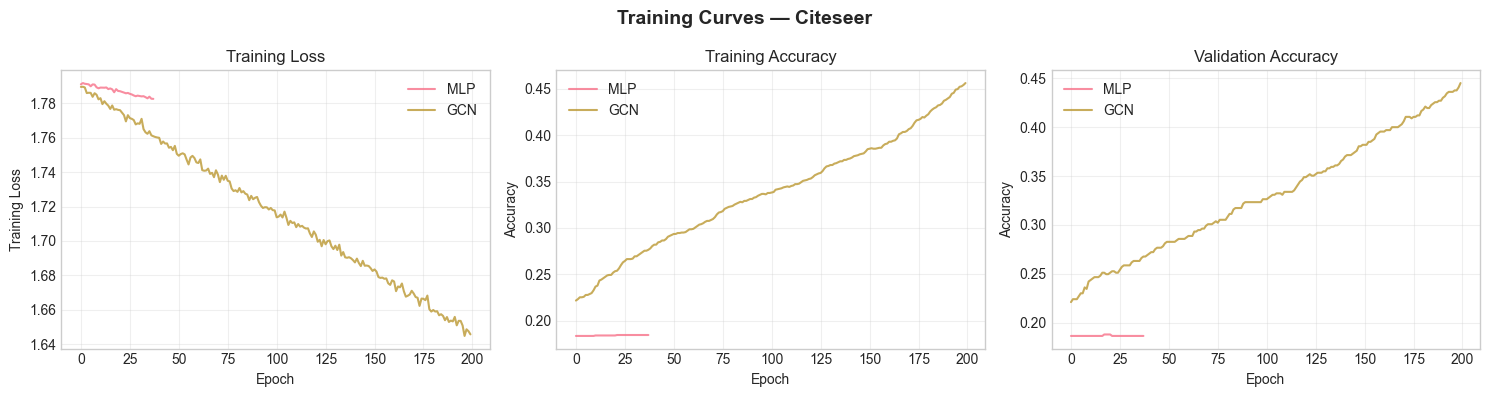

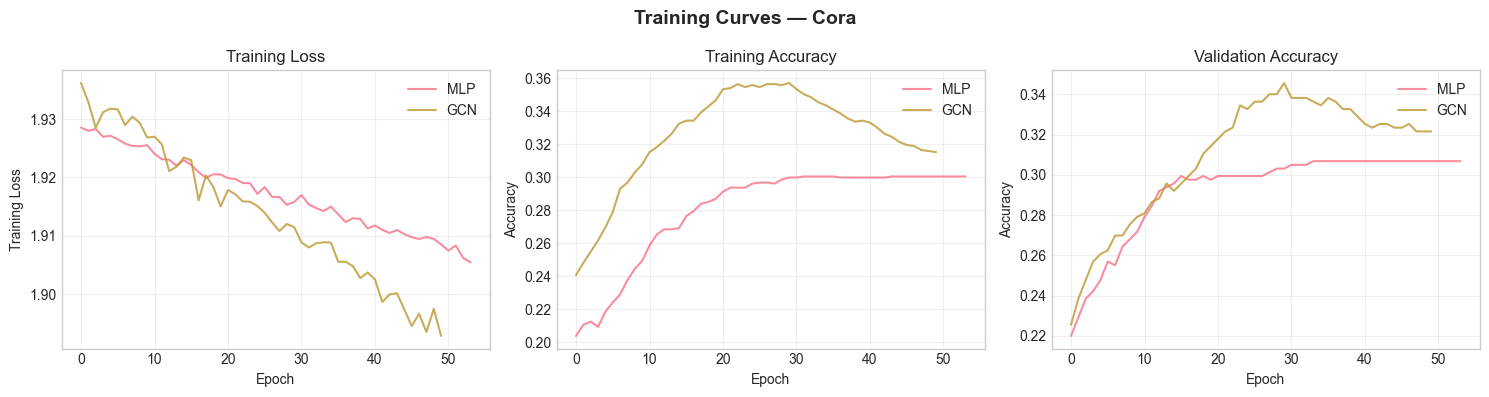

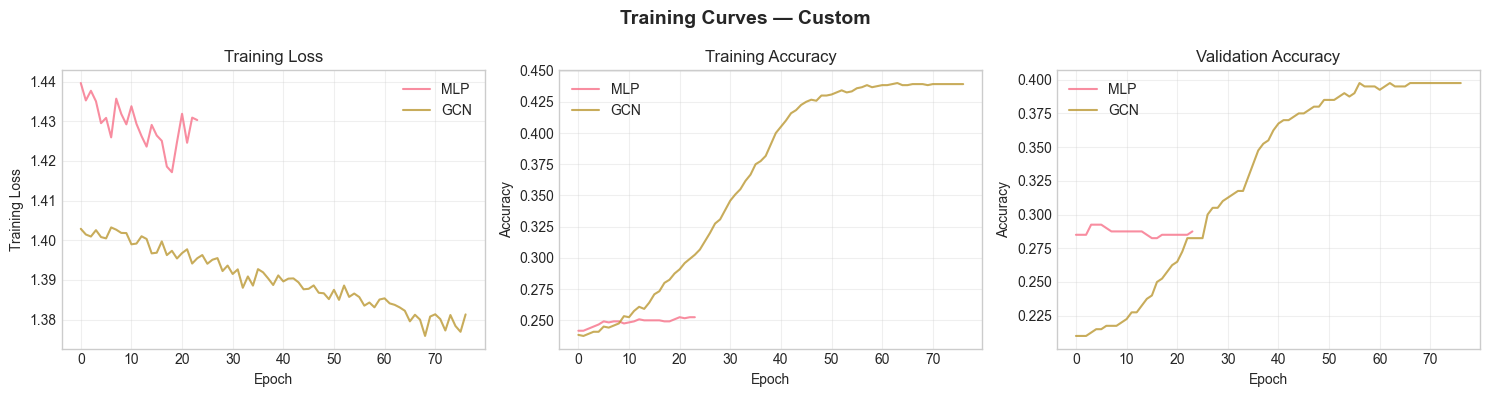

In [26]:
# Experiment: Optimizer
optimizers = ['Adam', 'SGD']
sweep_opt, trainers_opt = run_hyperparam_sweep('optimizer_type', optimizers, base_config, datasets_exp, exp_masks)
plot_hyperparam_sweep(sweep_opt, 'optimizer_type', optimizers,
                      'Comparación de Optimizadores', 'images/exp_optimizer.png')

# Summary table
display_sweep_table(sweep_opt, 'optimizer_type', 'Optimizer')

# Training curves for Adam
print("\n— Curvas de entrenamiento para optimizer = SGD —")
trainers_opt['SGD'].plot_training_curves(run = 0, filename = 'images/curves_sgd')

*(Espacio para análisis de optimizadores)*

#### Tabla resumen de todos los experimentos

In [27]:
# Consolidate all hyperparameter sweep results into one summary table
all_sweeps = []

for name, df, param_col in [
    ('Hidden Dims', sweep_hidden, 'hidden_channels'),
    ('Learning Rate', sweep_lr, 'lr'),
    ('Dropout', sweep_dropout, 'dropout'),
    ('Weight Decay', sweep_wd, 'weight_decay'),
    ('Optimizer', sweep_opt, 'optimizer_type'),
]:
    df_copy = df.copy()
    df_copy['Experiment'] = name
    df_copy['Param Value'] = df_copy[param_col].astype(str)
    df_copy['Accuracy'] = df_copy.apply(lambda r: f"{r['mean']:.4f} ± {r['std']:.4f}", axis = 1)
    df_copy['Avg Epochs'] = df_copy['avg_epochs'].apply(lambda x: f"{x:.0f}")
    all_sweeps.append(df_copy[['Experiment', 'Param Value', 'Dataset', 'Model', 'Accuracy', 'Avg Epochs']])

summary_all = pd.concat(all_sweeps, ignore_index = True)
summary_all

,Experiment,Param Value,Dataset,Model,Accuracy,Avg Epochs
0,Hidden Dims,16,Citeseer,GCN,0.7658 ± 0.0128,38
1,Hidden Dims,16,Citeseer,MLP,0.7255 ± 0.0139,44
2,Hidden Dims,16,Cora,GCN,0.8788 ± 0.0093,48
3,Hidden Dims,16,Cora,MLP,0.7477 ± 0.0174,78
4,Hidden Dims,16,Custom,GCN,0.9985 ± 0.0034,41
...,...,...,...,...,...,...
85,Optimizer,SGD,Citeseer,MLP,0.2652 ± 0.1014,105
86,Optimizer,SGD,Cora,GCN,0.2939 ± 0.0204,67
87,Optimizer,SGD,Cora,MLP,0.2177 ± 0.0898,46
88,Optimizer,SGD,Custom,GCN,0.3395 ± 0.2794,74


*(Espacio para discusión final: 3-4 párrafos comparando MLP vs GCN, análisis de hiperparámetros, y conclusiones generales)*